# Meta-Reinforcement Learning with MAML in a Gridworld (Improved)

This notebook implements an **improved and stabilized** version of MAML for an RL task. The goal is to train an agent that can quickly adapt to solve new maze configurations.

**Key Improvements:**
1.  **Reward Shaping:** The environment now provides a dense reward signal, guiding the agent towards the goal.
2.  **Stable Inner-Loop Updates:** The MAML algorithm now uses a standard optimizer for more stable adaptation.
3.  **Visual Evaluation:** A new section has been added to visualize the agent's performance before and after adaptation.

## 1. Installation and Imports

In [ ]:
!pip install -q torch numpy matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import random
import copy
import matplotlib.pyplot as plt


## 2. The Gridworld Environment with Reward Shaping

**IMPROVEMENT 1:** The `step` function is updated to include reward shaping. We calculate the Manhattan distance to the goal before and after the move. The agent is rewarded for getting closer.
This dense reward signal makes learning significantly easier and more stable.

In [ ]:
class GridWorldEnv:
    def __init__(self, size=5):
        self.size = size
        self.action_space = [0, 1, 2, 3] # 0:Up, 1:Down, 2:Left, 3:Right
        self.state = (0, 0)
        self.goal = (size - 1, size - 1)

    def set_goal(self, goal_pos):
        self.goal = goal_pos

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action):
        x, y = self.state
        gx, gy = self.goal
        
        dist_before = abs(x - gx) + abs(y - gy)

        if action == 0: y = min(self.size - 1, y + 1)
        elif action == 1: y = max(0, y - 1)
        elif action == 2: x = max(0, x - 1)
        elif action == 3: x = min(self.size - 1, x + 1)

        self.state = (x, y)
        dist_after = abs(x - gx) + abs(y - gy)

        done = (self.state == self.goal)
        if done:
            reward = 10.0
        else:
            # Reward shaping: reward for getting closer, penalize for moving away
            reward = (dist_before - dist_after) * 0.1 - 0.05
            
        return self.state, reward, done


## 3. The Policy Network (The Agent)

This remains the same. It's a simple network that maps state to action probabilities.

In [ ]:
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return self.net(state_tensor)


## 4. The MAML Algorithm for RL (Improved)

**IMPROVEMENT 2:** The `train` method is updated to use a standard `torch.optim.SGD` optimizer for the inner loop. This replaces the manual gradient update and provides more stability and is more conventional.

In [ ]:
class MAML:
    def __init__(self, env, policy, inner_lr=0.05, meta_lr=0.001, gamma=0.99, num_tasks=10, inner_steps=1, max_traj_len=25):
        self.env = env
        self.meta_policy = policy
        self.meta_optimizer = optim.Adam(self.meta_policy.parameters(), lr=meta_lr)
        self.inner_lr = inner_lr
        self.gamma = gamma
        self.num_tasks = num_tasks
        self.inner_steps = inner_steps
        self.max_traj_len = max_traj_len

    def sample_tasks(self):
        goals = [(random.randint(1, self.env.size-1), random.randint(1, self.env.size-1)) for _ in range(self.num_tasks)]
        return goals

    def collect_trajectories(self, policy, goal, record_path=False):
        self.env.set_goal(goal)
        state = self.env.reset()
        log_probs, rewards, path = [], [], [state]

        for _ in range(self.max_traj_len):
            action_probs = policy(state)
            dist = Categorical(action_probs)
            action = dist.sample()
            new_state, reward, done = self.env.step(action.item())
            log_probs.append(dist.log_prob(action))
            rewards.append(reward)
            state = new_state
            if record_path: path.append(state)
            if done: break
        if record_path: return log_probs, rewards, path
        return log_probs, rewards

    def calculate_loss(self, log_probs, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        policy_loss = [-log_prob * R for log_prob, R in zip(log_probs, returns)]
        return torch.cat(policy_loss).sum()

    def train(self, num_iterations=100):
        all_rewards = []
        for iteration in range(num_iterations):
            tasks = self.sample_tasks()
            meta_loss = 0.0
            iteration_rewards = []

            for task_goal in tasks:
                fast_policy = copy.deepcopy(self.meta_policy)
                # Use a standard optimizer for the inner loop for stability
                fast_optimizer = optim.SGD(fast_policy.parameters(), lr=self.inner_lr)

                # Inner Loop: Adapt to the current task
                for _ in range(self.inner_steps):
                    log_probs, rewards = self.collect_trajectories(fast_policy, task_goal)
                    inner_loss = self.calculate_loss(log_probs, rewards)
                    fast_optimizer.zero_grad()
                    inner_loss.backward()
                    fast_optimizer.step()

                # Evaluate the adapted model and accumulate meta-loss
                log_probs_meta, rewards_meta = self.collect_trajectories(fast_policy, task_goal)
                meta_loss += self.calculate_loss(log_probs_meta, rewards_meta)
                iteration_rewards.append(sum(rewards_meta))

            # Outer Loop: Update the meta-policy
            self.meta_optimizer.zero_grad()
            meta_loss /= self.num_tasks
            meta_loss.backward()
            self.meta_optimizer.step()
            
            avg_reward = np.mean(iteration_rewards)
            all_rewards.append(avg_reward)
            if (iteration + 1) % 20 == 0:
                print(f"Iteration {iteration+1}/{num_iterations}, Avg Reward: {avg_reward:.2f}")
        return all_rewards


## 5. Running the Meta-Training Process

We instantiate our components and start the training. Note the `inner_lr` and `max_traj_len` have been tuned.

Starting Meta-RL Training with MAML...
Iteration 20/300, Avg Reward: 0.98
Iteration 40/300, Avg Reward: 0.16
Iteration 60/300, Avg Reward: -0.40
Iteration 80/300, Avg Reward: 3.68
Iteration 100/300, Avg Reward: 1.72
Iteration 120/300, Avg Reward: 0.95
Iteration 140/300, Avg Reward: 0.33
Iteration 160/300, Avg Reward: 2.39
Iteration 180/300, Avg Reward: 1.57
Iteration 200/300, Avg Reward: 1.62
Iteration 220/300, Avg Reward: 0.93
Iteration 240/300, Avg Reward: -0.44
Iteration 260/300, Avg Reward: 0.95
Iteration 280/300, Avg Reward: 1.05
Iteration 300/300, Avg Reward: 1.05

Training finished!


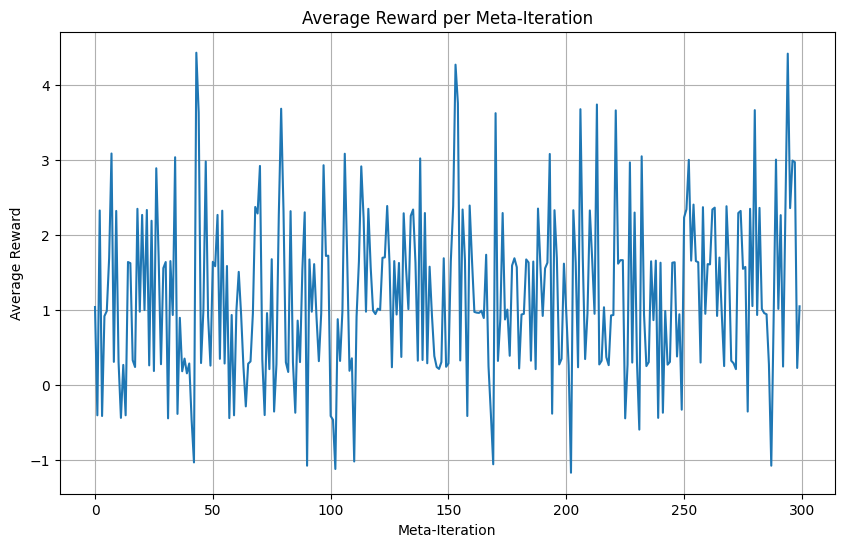

In [10]:
# Hyperparameters
GRID_SIZE = 5
STATE_DIM = 2
ACTION_DIM = 4
META_ITERATIONS = 300 # Increased for more training
TASKS_PER_ITERATION = 16
INNER_UPDATE_STEPS = 1
INNER_LR = 0.05 # Tuned learning rate
MAX_TRAJ_LEN = 25 # More reasonable trajectory length

# Initialization
env = GridWorldEnv(size=GRID_SIZE)
policy = Policy(input_size=STATE_DIM, output_size=ACTION_DIM)
maml_trainer = MAML(env, policy, inner_lr=INNER_LR, num_tasks=TASKS_PER_ITERATION, inner_steps=INNER_UPDATE_STEPS, max_traj_len=MAX_TRAJ_LEN)

print("Starting Meta-RL Training with MAML...")
rewards_history = maml_trainer.train(num_iterations=META_ITERATIONS)
print("\nTraining finished!")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(rewards_history)
plt.title('Average Reward per Meta-Iteration')
plt.xlabel('Meta-Iteration')
plt.ylabel('Average Reward')
plt.grid(True)
plt.show()


## 6. Test the Trained Meta-Agent

**NEW:** This cell demonstrates the power of the trained meta-agent. We test it on a new, unseen goal. 
1.  **Before Adaptation:** We see the path the initial meta-policy takes. It will likely be inefficient.
2.  **After Adaptation:** We adapt the policy with a few gradient steps on the new task and then show its new path. It should be much more direct and intelligent.


--- Testing Meta-Policy on a New Task ---


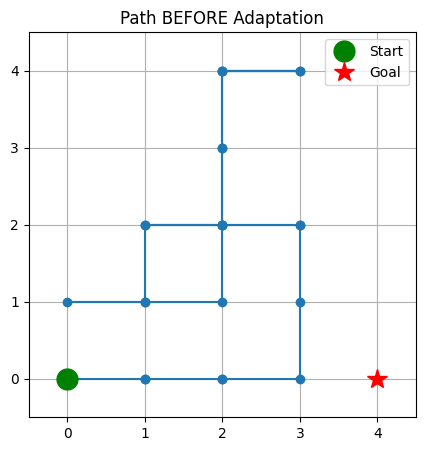

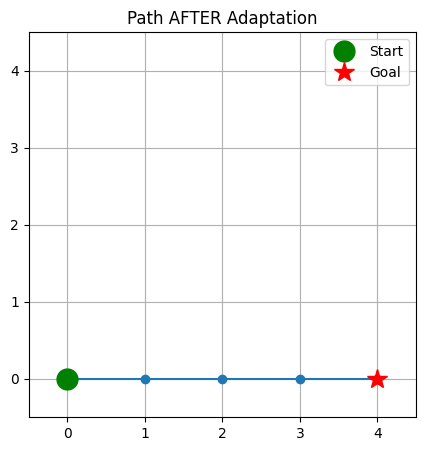

: 

In [ ]:
def plot_path(path, goal, title):
    path = np.array(path)
    plt.figure(figsize=(5, 5))
    plt.plot(path[:, 0], path[:, 1], marker='o', linestyle='-')
    plt.plot(path[0, 0], path[0, 1], 'go', markersize=15, label='Start') # Start
    plt.plot(goal[0], goal[1], 'r*', markersize=15, label='Goal') # Goal
    plt.grid(True)
    plt.xlim(-0.5, env.size - 0.5)
    plt.ylim(-0.5, env.size - 0.5)
    plt.title(title)
    plt.legend()
    plt.show()

print("\n--- Testing Meta-Policy on a New Task ---")
test_goal = (env.size - 1, 0) # A new, unseen goal

# 1. Test BEFORE adaptation
_, _, path_before = maml_trainer.collect_trajectories(maml_trainer.meta_policy, test_goal, record_path=True)
plot_path(path_before, test_goal, "Path BEFORE Adaptation")

# 2. Adapt the policy
adapted_policy = copy.deepcopy(maml_trainer.meta_policy)
adapter_optimizer = optim.SGD(adapted_policy.parameters(), lr=INNER_LR)
for _ in range(5): # Adapt for a few steps
    log_probs, rewards = maml_trainer.collect_trajectories(adapted_policy, test_goal)
    loss = maml_trainer.calculate_loss(log_probs, rewards)
    adapter_optimizer.zero_grad()
    loss.backward()
    adapter_optimizer.step()

# 3. Test AFTER adaptation
_, _, path_after = maml_trainer.collect_trajectories(adapted_policy, test_goal, record_path=True)
plot_path(path_after, test_goal, "Path AFTER Adaptation")
